### Import

In [89]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
import sys
import os

module_dir = "/storage/home/hcoda1/2/cmarutha3/clef/animalclef-2025/"
if module_dir not in sys.path:
    sys.path.append(module_dir)

In [91]:
import torch
import torch.nn
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import umap
from animalclef.spark import get_spark
from pathlib import Path
from pyspark.sql import functions as F, Window
from pyspark.sql import SparkSession

le = LabelEncoder()
print(torch.cuda.is_available())
print(torch.__version__)

True
2.6.0+cu124


CPU or CUDA

In [92]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [93]:
os.getcwd()

'/storage/scratch1/2/cmarutha3'

In [94]:
cwd = os.getcwd()
print("Current Working Directory:", cwd)
os.chdir(os.path.expanduser("~/scratch/"))
print("Changed Working Directory to:", os.getcwd())

Current Working Directory: /storage/scratch1/2/cmarutha3
Changed Working Directory to: /storage/scratch1/2/cmarutha3


In [95]:
spark = get_spark(cores=4, memory="4g")
display(spark)

metadata = spark.read.parquet(f"{Path.home()}/shared/animalclef/data/parquet/metadata")

db_embeddings_features = spark.read.parquet(
    f"{Path.home()}/shared/animalclef/data/embeddings/megadescriptor-l-384/db_embeddings_features.parquet"
)
db_embeddings_metadata = spark.read.parquet(
    f"{Path.home()}/shared/animalclef/data/embeddings/megadescriptor-l-384/db_embeddings_metadata.parquet"
)
query_embeddings_features = spark.read.parquet(
    f"{Path.home()}/shared/animalclef/data/embeddings/megadescriptor-l-384/query_embeddings_features.parquet"
)
query_embeddings_metadata = spark.read.parquet(
    f"{Path.home()}/shared/animalclef/data/embeddings/megadescriptor-l-384/query_embeddings_metadata.parquet"
)

25/04/26 14:21:06 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [96]:
# Database
df_db_embeddings_metadata = db_embeddings_metadata.toPandas()
df_db_embeddings_features = db_embeddings_features.toPandas()
df_db_embeddings_features["cls"] = df_db_embeddings_features.apply(
    lambda row: np.array(row, dtype=float), axis=1
)
df_db_embeddings_features["image_id"] = df_db_embeddings_metadata["image_id"]

# Query
df_query_embeddings_metadata = query_embeddings_metadata.toPandas()
df_query_embeddings_features = query_embeddings_features.toPandas()
df_query_embeddings_features["cls"] = df_query_embeddings_features.apply(
    lambda row: np.array(row, dtype=float), axis=1
)
df_query_embeddings_features["image_id"] = df_query_embeddings_metadata["image_id"]

In [97]:
spark = SparkSession.builder.appName("PandasToPySpark").getOrCreate()
db_embeddings = spark.createDataFrame(df_db_embeddings_features[["image_id", "cls"]])
query_embeddings = spark.createDataFrame(
    df_query_embeddings_features[["image_id", "cls"]]
)

25/04/26 14:21:17 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [98]:
combined_embeddings = db_embeddings.unionByName(query_embeddings)

df = metadata.join(combined_embeddings, on=["image_id"]).select(
    "image_id",
    "identity",
    "dataset",
    "cls",
    F.count("image_id").over(Window.partitionBy("identity")).alias("identity_count"),
)
df.printSchema()
df.show()

root
 |-- image_id: integer (nullable = true)
 |-- identity: string (nullable = true)
 |-- dataset: string (nullable = true)
 |-- cls: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- identity_count: long (nullable = false)



25/04/26 14:21:25 WARN TaskSetManager: Stage 30 contains a task of very large size (120126 KiB). The maximum recommended task size is 1000 KiB.


+--------+------------------+----------+--------------------+--------------+
|image_id|          identity|   dataset|                 cls|identity_count|
+--------+------------------+----------+--------------------+--------------+
|     329|LynxID2025_lynx_04|LynxID2025|[0.75290232896804...|             3|
|     472|LynxID2025_lynx_04|LynxID2025|[0.46819686889648...|             3|
|    3414|LynxID2025_lynx_04|LynxID2025|[0.19465856254100...|             3|
|    2264|LynxID2025_lynx_08|LynxID2025|[0.17942652106285...|             1|
|      17|LynxID2025_lynx_16|LynxID2025|[0.15272599458694...|            36|
|     189|LynxID2025_lynx_16|LynxID2025|[0.46724987030029...|            36|
|     407|LynxID2025_lynx_16|LynxID2025|[0.45012849569320...|            36|
|     686|LynxID2025_lynx_16|LynxID2025|[0.12884379923343...|            36|
|     697|LynxID2025_lynx_16|LynxID2025|[0.22342705726623...|            36|
|     717|LynxID2025_lynx_16|LynxID2025|[0.18744789063930...|            36|

In [99]:
df.write.parquet(
    f"{Path.home()}/shared/animalclef/data/parquet/df_megadescriptor_processed.parquet",
    mode="overwrite",
)

25/04/26 14:21:26 WARN TaskSetManager: Stage 34 contains a task of very large size (120126 KiB). The maximum recommended task size is 1000 KiB.


### Extract Data

In [100]:
df = spark.read.parquet(
    f"{Path.home()}/shared/animalclef/data/parquet/df_megadescriptor_processed.parquet"
)

In [101]:
pdf = df.toPandas()

In [102]:
pdf.head()

,image_id,identity,dataset,cls,identity_count
0,35,LynxID2025_lynx_01,LynxID2025,"[-0.00713190296664834, -0.012807803228497505, ...",28
1,401,LynxID2025_lynx_01,LynxID2025,"[-0.4014165997505188, -0.01850143074989319, 0....",28
2,464,LynxID2025_lynx_01,LynxID2025,"[0.2639135420322418, 0.18407802283763885, -0.0...",28
3,531,LynxID2025_lynx_01,LynxID2025,"[-0.08777263015508652, -0.32186010479927063, 0...",28
4,638,LynxID2025_lynx_01,LynxID2025,"[-0.05942385643720627, -0.4958280920982361, 0....",28


In [103]:
dataset = pdf["dataset"].unique()
count_dataset = pdf["dataset"].value_counts()
print("Count of Unique IDs:\n", count_dataset)

Count of Unique IDs:
 dataset
SeaTurtleID2022     9229
LynxID2025          3903
SalamanderID2025    2077
Name: count, dtype: int64


In [104]:
import warnings

warnings.filterwarnings("ignore", message="No data for colormapping provided")
warnings.filterwarnings(
    "ignore", message="'force_all_finite' was renamed to 'ensure_all_finite'"
)

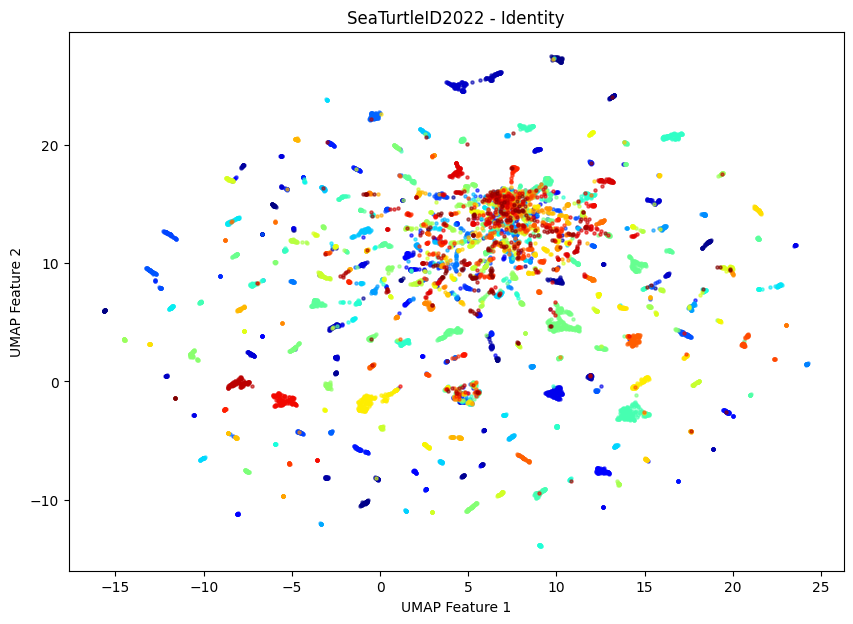

In [105]:
ds_seaturtleid2022 = pdf[pdf["dataset"] == "SeaTurtleID2022"]["identity"].unique()
count_ds_seaturtleid2022 = pdf[pdf["dataset"] == "SeaTurtleID2022"][
    "identity"
].value_counts()
pdf_select = pdf[
    pdf["identity"].isin(list(count_ds_seaturtleid2022.index)[0:])
].reset_index(drop=True)
pdf_select["identity"] = le.fit_transform(pdf_select["identity"])
pdf_select = pdf_select[["identity", "cls"]]
features = np.array(pdf_select["cls"].tolist())
labels = np.array(pdf_select["identity"].values)
umap_model = umap.UMAP(n_neighbors=5, min_dist=0.3, metric="correlation")
umap_embedding = umap_model.fit_transform(features)
unique_labels = np.unique(labels)
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))
color_map = dict(zip(unique_labels, colors))
plt.figure(figsize=(10, 7))
for label in unique_labels:
    indices = labels == label
    plt.scatter(
        umap_embedding[indices, 0],
        umap_embedding[indices, 1],
        color=color_map[label],
        label=le.inverse_transform([label])[0],
        cmap="Spectral",
        s=5,
        alpha=0.6,
    )
# plt.legend()
plt.title("SeaTurtleID2022 - Identity")
plt.xlabel("UMAP Feature 1")
plt.ylabel("UMAP Feature 2")
plt.show()

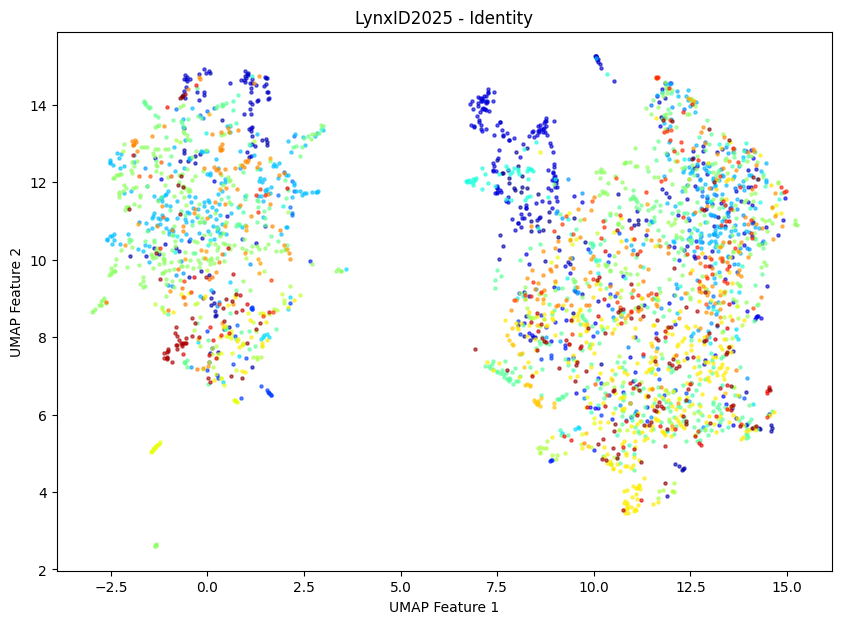

In [106]:
ds_lynxid2025 = pdf[pdf["dataset"] == "LynxID2025"]["identity"].unique()
count_ds_lynxid2025 = pdf[pdf["dataset"] == "LynxID2025"]["identity"].value_counts()
pdf_select = pdf[pdf["identity"].isin(list(count_ds_lynxid2025.index)[0:])].reset_index(
    drop=True
)
pdf_select["identity"] = le.fit_transform(pdf_select["identity"])
pdf_select = pdf_select[["identity", "cls"]]
features = np.array(pdf_select["cls"].tolist())
labels = np.array(pdf_select["identity"].values)
umap_model = umap.UMAP(n_neighbors=5, min_dist=0.3, metric="correlation")
umap_embedding = umap_model.fit_transform(features)
unique_labels = np.unique(labels)
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))
color_map = dict(zip(unique_labels, colors))
plt.figure(figsize=(10, 7))
for label in unique_labels:
    indices = labels == label
    plt.scatter(
        umap_embedding[indices, 0],
        umap_embedding[indices, 1],
        color=color_map[label],
        label=le.inverse_transform([label])[0],
        cmap="Spectral",
        s=5,
        alpha=0.6,
    )
# plt.legend()
plt.title("LynxID2025 - Identity")
plt.xlabel("UMAP Feature 1")
plt.ylabel("UMAP Feature 2")
plt.show()

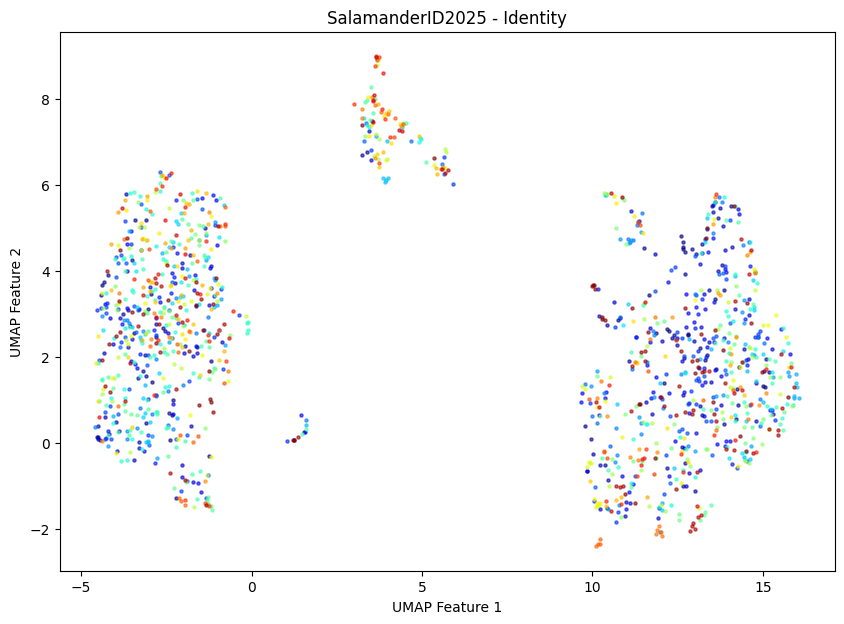

In [107]:
ds_salamanderid2025 = pdf[pdf["dataset"] == "SalamanderID2025"]["identity"].unique()
count_ds_salamanderid2025 = pdf[pdf["dataset"] == "SalamanderID2025"][
    "identity"
].value_counts()
pdf_select = pdf[
    pdf["identity"].isin(list(count_ds_salamanderid2025.index)[0:])
].reset_index(drop=True)
pdf_select["identity"] = le.fit_transform(pdf_select["identity"])
pdf_select = pdf_select[["identity", "cls"]]
features = np.array(pdf_select["cls"].tolist())
labels = np.array(pdf_select["identity"].values)
umap_model = umap.UMAP(n_neighbors=5, min_dist=0.3, metric="correlation")
umap_embedding = umap_model.fit_transform(features)
unique_labels = np.unique(labels)
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))
color_map = dict(zip(unique_labels, colors))
plt.figure(figsize=(10, 7))
for label in unique_labels:
    indices = labels == label
    plt.scatter(
        umap_embedding[indices, 0],
        umap_embedding[indices, 1],
        color=color_map[label],
        label=le.inverse_transform([label])[0],
        cmap="Spectral",
        s=5,
        alpha=0.6,
    )
# plt.legend()
plt.title("SalamanderID2025 - Identity")
plt.xlabel("UMAP Feature 1")
plt.ylabel("UMAP Feature 2")
plt.show()